# ECS 271: HW2
### Daniel Scalettar

# 0. Setup and Infrustructure

## 0.1 Imports and Device Selection 

Select device based on availability.
Use MPS or CUDA if possible for improved performance.

In [83]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [84]:
# device selection
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using MPS device


## 0.2 Load Data

In [80]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## 0.3 Define Helper Functions

In [75]:
def get_dataloaders(batch_size, num_workers=2):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)
    return trainloader, testloader

In [91]:
def train_and_evaluate(model, trainloader, testloader, criterion, optimizer, device, epochs=2):
    # parameters to track during training
    train_loss_history = []
    train_acc_history = []
    test_acc_history = []
    best_test_acc = 0.0
    # training loop
    for epoch in range(epochs):
        # set training mode
        model.train()
        # initialize parameters to track training accuracy
        train_total = 0
        train_correct = 0
        running_loss_epoch = 0.0
        running_loss_intermediate = 0.0
        # iterate over training data
        for i, data in enumerate(trainloader, 0):
            # get the inputs and move them to selected device
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            # print statistics
            running_loss_intermediate += loss.item()
            running_loss_epoch += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss_intermediate / 2000))
                running_loss_intermediate = 0.0
        # calculate epoch loss and training accuracy
        epoch_loss = running_loss_epoch / len(trainloader)
        epoch_train_acc = 100 * train_correct / train_total
        # set model to evaluate mode and evaluate on test data
        model.eval()
        test_total = 0
        test_correct = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        # calculate test accuracy and update histories
        epoch_test_acc = 100 * test_correct / test_total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_train_acc)
        test_acc_history.append(epoch_test_acc)
        # output epoch statistics
        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {epoch_loss:.3f}, Train Acc: {epoch_train_acc:.3f}%, Test Acc: {epoch_test_acc:.3f}%")
        # track best test accuracy
        if epoch_test_acc >= best_test_acc:
            best_test_acc = epoch_test_acc
    # output best test accuracy and return histories
    print(f"Best Test Acc: {best_test_acc:.3f}%")
    return train_loss_history, train_acc_history, test_acc_history

In [72]:
def plot_results(title, loss, train_acc, test_acc):
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(14, 6))
    
    # Plot 1: Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.title(f'Loss vs. Epochs: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, test_acc, label='Test Accuracy')
    plt.title(f'Accuracy vs. Epochs: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [53]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [90]:
def save_history(filename, train_loss, train_acc, test_acc):
    history = {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'test_acc': test_acc
    }
    with open(filename, 'wb') as f:
        pickle.dump(history, f)
    print(f"History saved to {filename}")

def load_history(filename):
    with open(filename, 'rb') as f:
        history = pickle.load(f)
    print(f"History loaded from {filename}")
    return history['train_loss'], history['train_acc'], history['test_acc']

# 1. Check Tutorial Model

*Run the tutorial code out of the box and make sure you get reasonable results. You will report these
results in Section 2, so no report needed here.*

In [85]:
class TutorialNet(nn.Module):
    def __init__(self):
        super(TutorialNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_tutorial = TutorialNet()

In [ ]:
net_tutorial = TutorialNet()
net_tutorial.to(device)

trainloader_tutorial, testloader_tutorial = get_dataloaders(batch_size=4, num_workers=2)

criterion_tutorial = nn.CrossEntropyLoss()
optimizer_tutorial = optim.SGD(net_tutorial.parameters(), lr=0.001, momentum=0.9)

train_loss_tutorial, train_acc_tutorial, test_acc_tutorial = train_and_evaluate(
    net_tutorial, trainloader_tutorial, testloader_tutorial, criterion_tutorial, optimizer_tutorial, device, epochs=2)

[1,  2000] loss: 2.189
[1,  4000] loss: 1.842
[1,  6000] loss: 1.694
[1,  8000] loss: 1.562
[1, 10000] loss: 1.508
[1, 12000] loss: 1.471
Epoch: 1/2, Train Loss: 1.700, Train Acc: 37.574%, Test Acc: 49.190%
[2,  2000] loss: 1.376
[2,  4000] loss: 1.378
[2,  6000] loss: 1.348
[2,  8000] loss: 1.317
[2, 10000] loss: 1.315
[2, 12000] loss: 1.276
Epoch: 2/2, Train Loss: 1.333, Train Acc: 52.062%, Test Acc: 54.250%
Best Test Acc: 54.250%


# 2. Single Fully Connected Layer

*Change the code to have only a single fully connected layer. The model will have a single layer that
connects the input to the output. What is the number of parameters? In PyTorch, ”nn.Linear” can
be used for fully connected layer.*

The image dimensions are $3 \times 32 \times 32$ since the image has $3$ color channels and a height and width of $32$.
We must flatten this image in order to input it into our single fully connected layer:
$$\text{Input Size} = 3 \times 32 \times 32 = 3072$$

The output is the number of classes:
$$\text{Output Size} = 10$$

Our single fully connected layer has weights between every input and every output, plus one bias for every output neuron:
$$\text{Parameters} = 3072 * 10 + 10 = 30730$$

In [93]:
class SingleLayerNet(nn.Module):
    def __init__(self):
        super(SingleLayerNet, self).__init__()
        self.fc = nn.Linear(3 * 32 * 32, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.fc(x)
        return x

In [ ]:
net_single = SingleLayerNet()
net_single.to(device)

trainloader_single, testloader_single = get_dataloaders(batch_size=4, num_workers=2)

criterion_single = nn.CrossEntropyLoss()
optimizer_single = optim.SGD(net_single.parameters(), lr=0.001, momentum=0.9)

train_loss_single, train_acc_single, test_acc_single = train_and_evaluate(
    net_single, trainloader_single, testloader_single, criterion_single, optimizer_single, device, epochs=50)
save_history("single_layer_history.pkl", train_loss_single, train_acc_single, test_acc_single)

[1,  2000] loss: 2.233
[1,  4000] loss: 2.176
[1,  6000] loss: 2.149
[1,  8000] loss: 2.129
[1, 10000] loss: 2.153
[1, 12000] loss: 2.130
Epoch: 1/50, Train Loss: 2.157, Train Acc: 32.266%, Test Acc: 31.820%
[2,  2000] loss: 2.084
[2,  4000] loss: 2.087
[2,  6000] loss: 2.074
[2,  8000] loss: 2.128
[2, 10000] loss: 2.132
[2, 12000] loss: 2.130
Epoch: 2/50, Train Loss: 2.109, Train Acc: 34.296%, Test Acc: 35.120%
[3,  2000] loss: 2.039
[3,  4000] loss: 2.088
[3,  6000] loss: 2.080
[3,  8000] loss: 2.082
[3, 10000] loss: 2.101
[3, 12000] loss: 2.107
Epoch: 3/50, Train Loss: 2.082, Train Acc: 35.140%, Test Acc: 33.550%
[4,  2000] loss: 2.051
[4,  4000] loss: 2.041
[4,  6000] loss: 2.068
[4,  8000] loss: 2.066
[4, 10000] loss: 2.058
[4, 12000] loss: 2.124
Epoch: 4/50, Train Loss: 2.068, Train Acc: 35.554%, Test Acc: 33.410%
[5,  2000] loss: 2.039
[5,  4000] loss: 2.029
[5,  6000] loss: 2.066
[5,  8000] loss: 2.079
[5, 10000] loss: 2.069
[5, 12000] loss: 2.061
Epoch: 5/50, Train Loss: 2.058

In [ ]:
save_history("single_layer_history.pkl", train_loss_single, train_acc_single, test_acc_single)

In [ ]:
plot_results("Single Fully Connected Layer", train_loss_single, train_acc_single, test_acc_single)

# 3. Multiple Fully Connect Layers

*Change the code to have multiple fully connected layers. Try having a layer from input to 110 neurons
and then a layer to 74 neurons, and finally a layer to 10 neurons, one for each category. What happens
if you use or not use ReLU after each layer? Describe why.*

# 4. Convolution and Maxpooling Layers

*Change the code by adding two convolutional layers along with maxpooling layers before the fully
connected layers. This will be similar to the example in the tutorial. Use this model for the following
sections.*

In [54]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # input: 3x32x32
        self.conv1 = nn.Conv2d(3, 6, 5) # output: 6x28x28
        self.pool = nn.MaxPool2d(2, 2) # output: 6x14x14
        self.conv2 = nn.Conv2d(6, 16, 5) # output: 16x10x10
        # output (after another pool): 16x5x5
        # fully connected layer input: 16*5*5=400
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # output: 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
net_base = CNN()
net_base.to(device)

trainloader_base, testloader_base = get_dataloaders(batch_size=4, num_workers=2)

criterion_base = nn.CrossEntropyLoss()
optimizer_base = optim.SGD(net_base.parameters(), lr=0.001, momentum=0.9)

train_loss_base, train_acc_base, test_acc_base = train_and_evaluate(
    net_base, trainloader_base, testloader_base, criterion_base, optimizer_base, device, epochs=50)
save_history("cnn_baseline_history.pkl", train_loss_base, train_acc_base, test_acc_base)

[1,  2000] loss: 2.188
[1,  4000] loss: 1.862
[1,  6000] loss: 1.693
[1,  8000] loss: 1.583
[1, 10000] loss: 1.533
[1, 12000] loss: 1.489
Epoch: 1/50, Train Loss: 1.712, Train Acc: 37.094%, Test Acc: 46.830%
[2,  2000] loss: 1.397
[2,  4000] loss: 1.372
[2,  6000] loss: 1.360
[2,  8000] loss: 1.336
[2, 10000] loss: 1.281
[2, 12000] loss: 1.255
Epoch: 2/50, Train Loss: 1.329, Train Acc: 52.476%, Test Acc: 56.430%
[3,  2000] loss: 1.196
[3,  4000] loss: 1.202
[3,  6000] loss: 1.196
[3,  8000] loss: 1.192
[3, 10000] loss: 1.187
[3, 12000] loss: 1.175
Epoch: 3/50, Train Loss: 1.189, Train Acc: 57.902%, Test Acc: 59.240%
[4,  2000] loss: 1.085
[4,  4000] loss: 1.104
[4,  6000] loss: 1.110
[4,  8000] loss: 1.112
[4, 10000] loss: 1.081
[4, 12000] loss: 1.095
Epoch: 4/50, Train Loss: 1.096, Train Acc: 61.156%, Test Acc: 60.790%
[5,  2000] loss: 1.009
[5,  4000] loss: 1.023
[5,  6000] loss: 1.029
[5,  8000] loss: 1.043
[5, 10000] loss: 1.016
[5, 12000] loss: 1.043
Epoch: 5/50, Train Loss: 1.028

In [ ]:
save_history("cnn_baseline_history.pkl", train_loss_base, train_acc_base, test_acc_base)

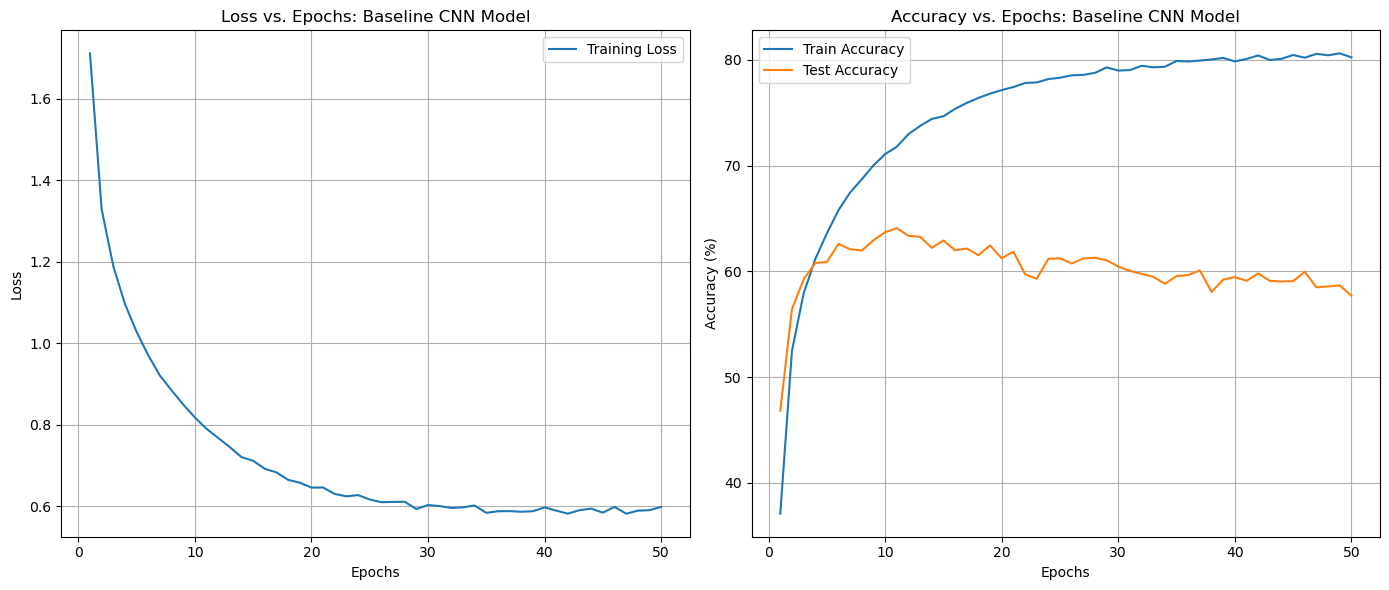

In [ ]:
plot_results("Baseline CNN Model", train_loss_base, train_acc_base, test_acc_base)

# 5. Batch Size Experimentation

*Try multiple batch sizes to see the effect and describe the findings. Please use batch size of 1, 4, and
1000. If 1000 does not fit into the memory of your machine, please feel free to reduce it to the largest
possible number.*

# 6. Learning Rate Experimentation

*Try multiple learning rates to see the effect and describe the findings. Please use learning rates of 10,
0.1, 0.01, and 0.001.*

# 7. Data Augmentation to Avoid Overfitting

*Please add some data augmentation to avoid overfitting. Note that you need to do this only for the
training and not the testing. You may use line 244-260 from Imagenet sample code:
https://github.com/pytorch/examples/blob/master/imagenet/main.py
”RandomResizedCrop” samples a random patch from the image to train the model on. ”RandomHorizontalFlip” flips randomly chosen images horizontally.*

# 8. Loss Function Experimentation

*Change the loss function from Cross Entropy to Mean Squared Error and report the effect.*